This notebook implements a submission with Gemma 3 12B IT model with some helper code to ensure the generated SVGs conform to the submission requirements. (See the [Evaluation](https://www.kaggle.com/competitions/drawing-with-llms/overview/evaluation) page for details on the submission requirements.)

To use this notebook interactively, you'll need to install some dependencies. First, *turn on* the Internet under **Session options** to the right. Then select the **Add-ons->Install Dependencies** menu above and click *Run*. A console should pop up with a running `pip` command. Wait for the dependencies to finish installing and then *turn off* the Internet before submitting.

In [1]:
ls /kaggle/input

d/  drawing-with-llms/  gemma-2/  gemma-3/  svg-constraints/


In [2]:
!pip install bitsandbytes cairosvg google_re2
!pip install --upgrade transformers
# !pip install git+https://github.com/huggingface/transformers@v4.49.0-Gemma-3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 22.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 546.8/546.8 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 63.4 MB/s eta 0:00:0000:010:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.0
    Uninstalling transformers-4.47.0:
      Successfully uninstalled transformers-4.47.0


In [3]:
import torch

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

2.5.1+cu121
True
2


In [4]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [5]:
# Make sure to run this installation command if not already installed:
#
from transformers import AutoTokenizer, BitsAndBytesConfig, Gemma3ForCausalLM, AutoConfig
# from transformers.models.gemma3 import Gemma3ForCausalLM, AutoConfig
import torch

DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


class Gemma3CodeGenerationPipeline:
    def __init__(self, gemma_path: str):
        
        self.gemma_path = gemma_path
        self.tokenizer = AutoTokenizer.from_pretrained(gemma_path)
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.float16,
        )
        # self.model = Gemma3ForCausalLM.from_pretrained(gemma_path, quantization_config=quantization_config).to(DEVICE)
        
        self.model = Gemma3ForCausalLM.from_pretrained(
            gemma_path,
            quantization_config=quantization_config,
            device_map="auto",
            low_cpu_mem_usage=True
        )
        self.model.gradient_checkpointing_enable()

        print(self.model.hf_device_map)

        # Try doing a simple inference step to force loading the weights
        test_input = self.tokenizer("test", return_tensors="pt").to(DEVICE)
        self.model.generate(**test_input, max_new_tokens=1)
    
        # config = AutoConfig.from_pretrained(gemma_path)
        # config.vocab_size = 256000
        # self.model = Gemma3ForCausalLM.from_pretrained(gemma_path, config=config, device_map="auto")

    def generate_response(self, prompt: str, max_new_tokens: int = 512) -> str:
        
        input_ids = self.tokenizer(text=prompt, return_tensors="pt").to(DEVICE)
        outputs = self.model.generate(**input_ids, max_new_tokens=max_new_tokens)
        generated_text = self.tokenizer.batch_decode(
            outputs, skip_special_tokens=True, clean_up_tokenization_spaces=True
        )[0]
        return generated_text

    def optimize_code(self, code: str, custom_prompt: str = None, max_new_tokens: int = 256) -> str:
        
        if custom_prompt is None:
            # Default prompt instructs the model to provide multiple sections in its output.
            prompt = (
                "<start_of_turn>user:\n"
                "I have the following code:\n"
                f"{code}\n"
                "Could you provide an optimized version of this code along with detailed technical explanations? "
                "Include the following sections in your response:\n"
                "1. Optimized Code\n"
                "2. Technical Details\n"
                "3. Algorithmic Complexity (Big-O Analysis)\n"
                "4. Real World Application\n"
                "<end_of_turn>\n"
                "<start_of_turn>model:"
            )
        else:
            # Use the custom prompt provided by the user.
            prompt = (
                "<start_of_turn>user:\n"
                f"{custom_prompt}\n"
                f"{code}\n"
                "<end_of_turn>\n"
                "<start_of_turn>model:"
            )
        
        return self.generate_response(prompt, max_new_tokens=max_new_tokens)


In [6]:
prompt_template = """Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. Always give the complete SVG code with nothing omitted. Never use an ellipsis.

<description>"{}"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
"""
prompt = prompt_template.format("a purple forest at dusk")
print(prompt)

Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. Always give the complete SVG code with

In [7]:
GEMMA_PATH = "/kaggle/input/gemma-3/transformers/gemma-3-12b-it/1"
pipeline = Gemma3CodeGenerationPipeline(gemma_path=GEMMA_PATH)

prompt_template = """Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. Always give the complete SVG code with nothing omitted. Never use an ellipsis.

<description>"{}"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
"""
prompt = prompt_template.format("a purple forest at dusk")
# print(prompt)
response = pipeline.generate_response(prompt, max_new_tokens=512)
print("Generated Code Response:\n", response)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

{'model.embed_tokens': 0, 'lm_head': 0, 'model.layers.0': 0, 'model.layers.1': 0, 'model.layers.2': 0, 'model.layers.3': 0, 'model.layers.4': 0, 'model.layers.5': 0, 'model.layers.6': 0, 'model.layers.7': 0, 'model.layers.8': 0, 'model.layers.9': 0, 'model.layers.10': 0, 'model.layers.11': 1, 'model.layers.12': 1, 'model.layers.13': 1, 'model.layers.14': 1, 'model.layers.15': 1, 'model.layers.16': 1, 'model.layers.17': 1, 'model.layers.18': 1, 'model.layers.19': 1, 'model.layers.20': 1, 'model.layers.21': 1, 'model.layers.22': 1, 'model.layers.23': 1, 'model.layers.24': 1, 'model.layers.25': 1, 'model.layers.26': 1, 'model.layers.27': 1, 'model.layers.28': 1, 'model.layers.29': 1, 'model.layers.30': 1, 'model.layers.31': 1, 'model.layers.32': 1, 'model.layers.33': 1, 'model.layers.34': 1, 'model.layers.35': 1, 'model.layers.36': 1, 'model.layers.37': 1, 'model.layers.38': 1, 'model.layers.39': 1, 'model.layers.40': 1, 'model.layers.41': 1, 'model.layers.42': 1, 'model.layers.43': 1, 'm

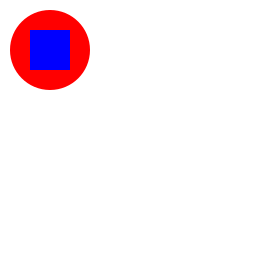

In [9]:
import cairosvg
from IPython.display import SVG
import re

matches = re.findall(r"<svg.*?</svg>", response, re.DOTALL | re.IGNORECASE)

svg = matches[-1]


cairosvg.svg2png(bytestring=svg.encode('utf-8'))

display(SVG(svg))


In [ ]:
#| export
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import concurrent
import io
import logging
import re
import re2

import cairosvg
import kagglehub
import torch
from lxml import etree
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from transformers.models.gemma3 import Gemma3ForConditionalGeneration, Gemma3Processor

svg_constraints = kagglehub.package_import('metric/svg-constraints')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Model:
    def __init__(self):
        # Quantization Configuration
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.float16,
        )

        # set max memory
        # T4x2
        max_memory = {
            0: "15GB",
            1: "15GB",
        }
        # # P100
        # max_memory = {
        #     0: "16GB",
        # }

        
        # self.model_path = kagglehub.model_download('deepseek-ai/deepseek-r1/transformers/deepseek-r1/1')
        # self.tokenizer = AutoTokenizer.from_pretrained(self.model_path)
        # # self.model = AutoModelForCausalLM.from_pretrained(
        # #     self.model_path,
        # #     device_map="auto",
        # #     quantization_config=quantization_config,
        # # )
        # self.model = AutoModelForCausalLM.from_pretrained(
        #     self.model_path,
        #     device_map="auto",
        # )
        # # self.model = AutoModelForCausalLM.from_pretrained(
        # #     self.model_path,
        # #     device_map="auto",
        # #     max_memory=max_memory,
        # # )

        GEMMA_PATH = kagglehub.model_download("google/gemma-3/transformers/gemma-3-12b-it")
        # model = Gemma3ForConditionalGeneration.from_pretrained(
        #             "google/gemma-3-27b-it",
        #             torch_dtype=torch.bfloat16,
        #             device_map="auto",
        #             quantization_config=quantization_config
        #         )
        self.processor = Gemma3Processor.from_pretrained(GEMMA_PATH, quantization_config=quantization_config)
        self.model = Gemma3ForConditionalGeneration.from_pretrained(GEMMA_PATH, torch_dtype=torch.float16).to(DEVICE)

        self.model.gradient_checkpointing_enable()

        print(self.model.hf_device_map)
        
        self.prompt_template = """Generate SVG code to visually represent the following text description, while respecting the given constraints.
<constraints>
* **Allowed Elements:** `svg`, `path`, `circle`, `rect`, `ellipse`, `line`, `polyline`, `polygon`, `g`, `linearGradient`, `radialGradient`, `stop`, `defs`
* **Allowed Attributes:** `viewBox`, `width`, `height`, `fill`, `stroke`, `stroke-width`, `d`, `cx`, `cy`, `r`, `x`, `y`, `rx`, `ry`, `x1`, `y1`, `x2`, `y2`, `points`, `transform`, `opacity`
</constraints>

<example>
<description>"A red circle with a blue square inside"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
  <circle cx="50" cy="50" r="40" fill="red"/>
  <rect x="30" y="30" width="40" height="40" fill="blue"/>
</svg>
```
</example>


Please ensure that the generated SVG code is well-formed, valid, and strictly adheres to these constraints. Focus on a clear and concise representation of the input description within the given limitations. Always give the complete SVG code with nothing omitted. Never use an ellipsis.

<description>"{}"</description>
```svg
<svg viewBox="0 0 256 256" width="256" height="256">
"""
        self.default_svg = """<svg width="256" height="256" viewBox="0 0 256 256"><circle cx="50" cy="50" r="40" fill="red" /></svg>"""
        self.constraints = svg_constraints.SVGConstraints()
        self.timeout_seconds = 90

    
    
    # You could try increasing `max_new_tokens`
    def predict(self, description: str, max_new_tokens=512) -> str:
        def generate_svg():
            try:
                prompt = self.prompt_template.format(description)
                # inputs = self.tokenizer(text=prompt, return_tensors="pt").to(DEVICE)
                inputs = self.processor(text=prompt, return_tensors="pt").to(DEVICE)
                

                with torch.no_grad():
                    # output = self.model.generate(
                    #     **inputs,
                    #     max_new_tokens=max_new_tokens,
                    #     do_sample=True,
                    # )
                    outputs = model.generate(**inputs, max_new_tokens=max_new_tokens)
                    text = processor.batch_decode(
                        outputs,
                        skip_special_tokens=True,
                        clean_up_tokenization_spaces=False
                    )

                # output_decoded = self.tokenizer.decode(output[0], skip_special_tokens=True)
                output_decoded = text[0]
                logging.debug('Output decoded from model: %s', output_decoded)

                matches = re.findall(r"<svg.*?</svg>", output_decoded, re.DOTALL | re.IGNORECASE)
                if matches:
                    svg = matches[-1]
                else:
                    return self.default_svg

                logging.debug('Unprocessed SVG: %s', svg)
                svg = self.enforce_constraints(svg)
                logging.debug('Processed SVG: %s', svg)
                # Ensure the generated code can be converted by cairosvg
                cairosvg.svg2png(bytestring=svg.encode('utf-8'))
                return svg
            except Exception as e:
                logging.error('Exception during SVG generation: %s', e)
                print('Exception during SVG generation: %s', e)
                return self.default_svg

        # Execute SVG generation in a new thread to enforce time constraints
        with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
            future = executor.submit(generate_svg)
            try:
                return future.result(timeout=self.timeout_seconds)
            except concurrent.futures.TimeoutError:
                logging.warning("Prediction timed out after %s seconds.", self.timeout_seconds)
                return self.default_svg
            except Exception as e:
                logging.error(f"An unexpected error occurred: {e}")
                return self.default_svg

    def enforce_constraints(self, svg_string: str) -> str:
        """Enforces constraints on an SVG string, removing disallowed elements
        and attributes.

        Parameters
        ----------
        svg_string : str
            The SVG string to process.

        Returns
        -------
        str
            The processed SVG string, or the default SVG if constraints
            cannot be satisfied.
        """
        logging.info('Sanitizing SVG...')

        try:
            parser = etree.XMLParser(remove_blank_text=True, remove_comments=True)
            root = etree.fromstring(svg_string, parser=parser)
        except etree.ParseError as e:
            logging.error('SVG Parse Error: %s. Returning default SVG.', e)
            return self.default_svg
    
        elements_to_remove = []
        for element in root.iter():
            tag_name = etree.QName(element.tag).localname
    
            # Remove disallowed elements
            if tag_name not in self.constraints.allowed_elements:
                elements_to_remove.append(element)
                continue  # Skip attribute checks for removed elements
    
            # Remove disallowed attributes
            attrs_to_remove = []
            for attr in element.attrib:
                attr_name = etree.QName(attr).localname
                if (
                    attr_name
                    not in self.constraints.allowed_elements[tag_name]
                    and attr_name
                    not in self.constraints.allowed_elements['common']
                ):
                    attrs_to_remove.append(attr)
    
            for attr in attrs_to_remove:
                logging.debug(
                    'Attribute "%s" for element "%s" not allowed. Removing.',
                    attr,
                    tag_name,
                )
                del element.attrib[attr]
    
            # Check and remove invalid href attributes
            for attr, value in element.attrib.items():
                 if etree.QName(attr).localname == 'href' and not value.startswith('#'):
                    logging.debug(
                        'Removing invalid href attribute in element "%s".', tag_name
                    )
                    del element.attrib[attr]

            # Validate path elements to help ensure SVG conversion
            if tag_name == 'path':
                d_attribute = element.get('d')
                if not d_attribute:
                    logging.warning('Path element is missing "d" attribute. Removing path.')
                    elements_to_remove.append(element)
                    continue # Skip further checks for this removed element
                # Use regex to validate 'd' attribute format
                path_regex = re2.compile(
                    r'^'  # Start of string
                    r'(?:'  # Non-capturing group for each command + numbers block
                    r'[MmZzLlHhVvCcSsQqTtAa]'  # Valid SVG path commands (adjusted to exclude extra letters)
                    r'\s*'  # Optional whitespace after command
                    r'(?:'  # Non-capturing group for optional numbers
                    r'-?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?'  # First number
                    r'(?:[\s,]+-?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?)*'  # Subsequent numbers with mandatory separator(s)
                    r')?'  # Numbers are optional (e.g. for Z command)
                    r'\s*'  # Optional whitespace after numbers/command block
                    r')+'  # One or more command blocks
                    r'\s*'  # Optional trailing whitespace
                    r'$'  # End of string
                )
                if not path_regex.match(d_attribute):
                    logging.warning(
                        'Path element has malformed "d" attribute format. Removing path.'
                    )
                    elements_to_remove.append(element)
                    continue
                logging.debug('Path element "d" attribute validated (regex check).')
        
        # Remove elements marked for removal
        for element in elements_to_remove:
            if element.getparent() is not None:
                element.getparent().remove(element)
                logging.debug('Removed element: %s', element.tag)

        try:
            cleaned_svg_string = etree.tostring(root, encoding='unicode')
            return cleaned_svg_string
        except ValueError as e:
            logging.error(
                'SVG could not be sanitized to meet constraints: %s', e
            )
            return self.default_svg

The following code tests the above model in a local mock-up of this competition's evaluation pipeline. It runs the model on a sample of 15 instances defined in the `test.csv` file in the `kaggle_evaluation` package folder.

In [ ]:
import kaggle_evaluation

logging.basicConfig(level=logging.INFO, force=True)
kaggle_evaluation.test(Model)

Alternatively, you could use the code below to run the model over `train.csv` and see some generated images along with some debugging info. Feel free to turn down the logging level to `INFO` if you just want to see the images.

In [ ]:
def generate():
    import polars as pl
    from IPython.display import SVG
    import time  # Import the time module
    
    logging.basicConfig(level=logging.DEBUG, force=True)
    
    train = pl.read_csv('/kaggle/input/drawing-with-llms/train.csv')
    display(train.head())
    
    model = Model()
    svgs = []
    for desc in train.get_column('description'):
        start_time = time.time()  # Record start time
        svg = model.predict(desc, max_new_tokens=512)
        end_time = time.time()    # Record end time
        elapsed_time = end_time - start_time # Calculate elapsed time
        print(f"Prediction time for description '{desc[:20]}...': {elapsed_time:.4f} seconds") # Print time
    
        try:
            display(SVG(svg))
        except Exception as e:
            print(e)
            continue

# Uncomment and run the line below to see some generated images
generate()